In [2]:
import xarray as xr

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from bs_fdbck.constants import measurements_path, path_outdata, path_extract_latlon_outdata

 from pathlib import Path 
 Path(path).mkdir(exist_ok=True, parents=True)


In [3]:
xr.set_options(keep_attrs=True) 

In [4]:
path_extract_latlon_outdata

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset')

In [5]:
lat_smr = 61.85
lon_smr = 24.28

In [6]:
fn1 = Path('/proj/bolinc/users/x_sarbl/noresm_archive/OsloAero_intBVOC_f19_f19_mg17_full/atm/OsloAero_intBVOC_f19_f19_mg17_full.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0.nc')

In [7]:
fn1.stem

'OsloAero_intBVOC_f19_f19_mg17_full.h1._2012-01-01-2015-01-01_concat_subs_22.0-30.0_60.0-66.0'

In [8]:
fn1_2 = fn1.parent / f'{fn1.stem}_sort.nc'

In [9]:
fn2 = path_extract_latlon_outdata/ 'OsloAero_intBVOC_f19_f19_mg17_ssp245/OsloAero_intBVOC_f19_f19_mg17_ssp245.h1._2015-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0.nc'

In [10]:
fn2_2 = fn2.parent / f'{fn2.stem}_sort.nc'

In [11]:
case_name = 'OsloAero_intBVOC_f19_f19_mg17_full'


cases = [case_name]

In [12]:
from pathlib import Path

In [13]:
plot_path = Path('Plots')

In [14]:
def make_fn(case, v_x, v_y):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'scat_{case}_{_x}_{_y}.png'
    return plot_path /f

In [15]:
plot_path.mkdir(exist_ok=True, parents=True)

In [16]:
varl =['DOD500','DOD440','ACTREL','ACTNL','TGCLDLWP', #,'SOA_A1',
       'H2SO4','SOA_LV','COAGNUCL','FORMRATE','T','FCTL',
       'TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP',
       'TAUTLOGMODIS',
       'MEANTAU_ISCCP',
       'LWPMODIS','CLWMODIS','REFFCLWMODIS','TAUTMODIS','TAUWMODIS',
      
      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3', 
      ] 

In [17]:
varl_st = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3']

## Load observations: 

## Open model dataset: 


ds_mod1 = xr.open_dataset(fn1, chunks = {'time':48})#[fn1,fn2])#.sortby('time')
ds_mod2 = xr.open_dataset(fn2, chunks = {'time':48})

varl1 = set(ds_mod1.data_vars)

varl2 = set(ds_mod2.data_vars)


varl =list(varl1.intersection(varl2))

ds_mod1 = ds_mod1[varl].sortby('time').sel(time=slice('2012','2014'))

ds_mod2 = ds_mod2[varl].sortby('time').sel(time=slice('2015','2018'))

ds_mod1

In [18]:
import dask.array as da
from dask.diagnostics import ProgressBar

delayed_obj = ds_mod1.to_netcdf(fn1_2, compute=False)
with ProgressBar():
    results = delayed_obj.compute()
    
    

delayed_obj = ds_mod2.to_netcdf(fn2_2, compute=False)
with ProgressBar():
    results = delayed_obj.compute()

ds_mod = xr.open_mfdataset([fn1_2,fn2_2], combine='by_coords', concat_dim='time')

In [19]:
fn_comb = path_extract_latlon_outdata/ 'OsloAero_intBVOC_f19_f19_mg17_fssp245'/'OsloAero_intBVOC_f19_f19_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0.nc'

In [20]:
fn_comb_lev1 = path_extract_latlon_outdata/ 'OsloAero_intBVOC_f19_f19_mg17_fssp245'/'OsloAero_intBVOC_f19_f19_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev-1.nc'
fn_comb_lev1_dailymedian = path_extract_latlon_outdata/ 'OsloAero_intBVOC_f19_f19_mg17_fssp245'/'OsloAero_intBVOC_f19_f19_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev-1_dailymedian.nc'




In [21]:
fn_comb.parent.mkdir(exist_ok=True,)


delayed_obj = ds_mod.to_netcdf(fn_comb, compute = False)
with ProgressBar():
    results = delayed_obj.compute()

ds_mod = xr.concat([ds_mod1[varl].sel(time=slice('2012','2014')), ds_mod2[varl].sel(time=slice('2015','2018'))], dim='time')

Load data: 


ds_mod = xr.open_dataset(fn_comb) 

ds_mod.compute()

ds_mod.load()

Somehow unsorted

ds_mod = ds_mod.sortby('time')

### Select hyytiala grid cell: 

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

ds_mod['TOT_ICLD_VISTAU_s']= ds_mod['TOT_ICLD_VISTAU'].sum('lev')
ds_mod['TOT_CLD_VISTAU_s']= ds_mod['TOT_CLD_VISTAU'].sum('lev')


model_lev_i=-1
ds_sel = ds_mod.sel(lat = lat_smr, lon= lon_smr, method='nearest').isel( lev=model_lev_i)#.load()
ds_all = ds_mod.isel(lev=model_lev_i)#.load()

#ds_sel.load()
#ds_all.load()

ds_all.to_netcdf(fn_comb_lev1)

In [22]:
model_lev_i=-1

In [23]:
ds_all = xr.open_dataset(fn_comb_lev1).isel(ilev=model_lev_i, nbnd=0)
ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( ilev=model_lev_i)#.load()

In [24]:
ds_mod = ds_all

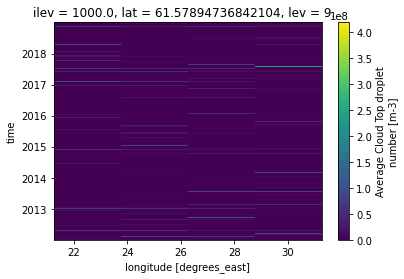

In [25]:
ds_all['ACTNL'].isel(lat=0).plot()

In [26]:
dic_ds=dict()
dic_ds[case_name]= ds_mod

### Broadcast ds_sel to same grid 

Copying the same for as hyytiala for all grid cells for the station variables (st measurements) 

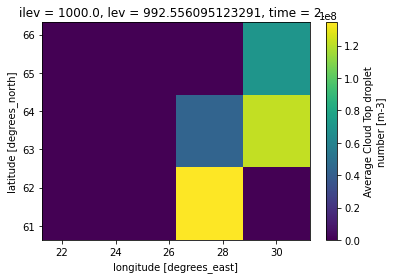

In [27]:
ds_all['ACTNL'].load().isel(time=20000).plot()

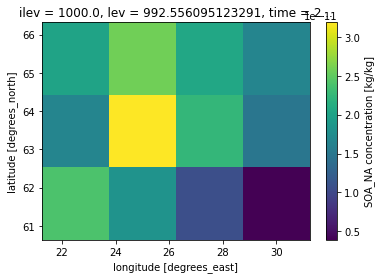

In [28]:
ds_all['SOA_NA'].load().isel(time=20000).plot()

In [29]:
ds_1, ds_2 =xr.broadcast(ds_sel, ds_all)
for v in varl_st:
    ds_all[v] = ds_1[v]

In [30]:
ds_sel

<xarray.Dataset>
Dimensions:            (time: 61488)
Coordinates:
    ilev               float64 1e+03
    lat                float64 61.58
    lev                float64 992.6
    lon                float64 25.0
  * time               (time) datetime64[ns] 2012-01-02 ... 2018-12-31T23:00:00
Data variables: (12/175)
    GRIDAREA           (time) float32 ...
    FLNT_DRF           (time) float32 ...
    GRH2SO4            (time) float32 ...
    co2vmr             (time) float64 ...
    OD550DRY           (time) float32 ...
    DERGT05            (time) float32 ...
    ...                 ...
    SFmonoterp         (time) float32 ...
    CCN3               (time) float32 ...
    D500_POM           (time) float32 ...
    nsbase             (time) int32 ...
    TOT_ICLD_VISTAU_s  (time) float32 ...
    TOT_CLD_VISTAU_s   (time) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              OsloAero_intBVOC_f19_f19_mg17_full
    logname:           x_sarbl
    host:              
    initial_file:      OsloAero_intBVOC_f19_f19_spinup.cam.i.2011-01-01-00000.nc
    topography_file:   /proj/cesm_input-data/inputdata/noresm-only/inputForNu...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1
    history:           Thu Mar 17 10:10:51 2022: ncrcat /proj/bolinc/users/x_...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

### Set dic_ds : 

In [31]:
dic_ds[case_name] =ds_all

Constants:

In [32]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9

In [33]:
ds_all.load()

<xarray.Dataset>
Dimensions:            (time: 61488, lat: 3, lon: 4)
Coordinates:
    ilev               float64 1e+03
  * lat                (lat) float64 61.58 63.47 65.37
    lev                float64 992.6
  * lon                (lon) float64 22.5 25.0 27.5 30.0
  * time               (time) datetime64[ns] 2012-01-02 ... 2018-12-31T23:00:00
Data variables: (12/175)
    GRIDAREA           (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FLNT_DRF           (time, lat, lon) float32 153.4 150.5 ... 163.3 163.1
    GRH2SO4            (time, lat, lon) float32 2.582e-05 ... 6.333e-06
    co2vmr             (time) float64 0.000392 0.000392 ... 0.0004101 0.0004101
    OD550DRY           (time, lat, lon) float32 0.01579 0.01606 ... 0.009979
    DERGT05            (time, lat, lon) float32 1.21 1.217 1.21 ... 1.22 1.216
    ...                 ...
    SFmonoterp         (time, lat, lon) float32 3.658e-12 ... 9.629e-13
    CCN3               (time, lat, lon) float32 38.65 38.58 4.37 ... 4.766 5.032
    D500_POM           (time, lat, lon) float32 0.01969 0.0151 ... 0.007325
    nsbase             (time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    TOT_ICLD_VISTAU_s  (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TOT_CLD_VISTAU_s   (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              OsloAero_intBVOC_f19_f19_mg17_full
    logname:           x_sarbl
    host:              
    initial_file:      OsloAero_intBVOC_f19_f19_spinup.cam.i.2011-01-01-00000.nc
    topography_file:   /proj/cesm_input-data/inputdata/noresm-only/inputForNu...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1
    history:           Thu Mar 17 10:10:51 2022: ncrcat /proj/bolinc/users/x_...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

In [33]:
def get_dic_df_mod(model_lev_i=-1):
    


SyntaxError: unexpected EOF while parsing (120339897.py, line 2)

In [34]:
    dic_df = dict()
    dic_df_sm = dict()

    for ca in dic_ds.keys():
        ds = dic_ds[ca]
        #ds['TOT_ICLD_VISTAU_s']= ds['TOT_ICLD_VISTAU'].sum('lev')
        #ds['TOT_CLD_VISTAU_s']= ds['TOT_CLD_VISTAU'].sum('lev')
        for v in ['TGCLDLWP','TGCLDIWP','TGCLDCWP']:
            if v in ds.data_vars:
                if ds[v].attrs['units'] =='kg/m2':
                    ds[v] = ds[v]*1000
                    ds[v].attrs['units'] = 'g/m2'
                
        
        ds_sel = ds.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( lev=model_lev_i)

In [35]:
        ds_all = ds#.isel(lev=model_lev_i)
        ds_sel =ds_sel[varl_st]
       
        s_1, ds_2 =xr.broadcast(ds_sel, ds_all)
        for v in varl_st:
            ds_all[v] = ds_1[v]
        ds_sel = ds_all
        rho = pressure*100/(R*ds_sel['T'])

In [36]:
        ds_sel['rho'] = rho
        ds_sel['ACTNL_incld'] = ds_sel['ACTNL']/ds_sel['FCTL']
        ds_sel['ACTREL_incld'] = ds_sel['ACTREL']/ds_sel['FCTL']

In [38]:
        ds_sel_median = ds_sel.resample({'time':'D'}).median()

(array([1.6305e+04, 9.4900e+02, 1.1400e+02, 2.7000e+01, 8.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.1875005e+03, 9.3798416e+07, 1.8759563e+08, 2.8139286e+08,
        3.7519008e+08, 4.6898733e+08, 5.6278451e+08, 6.5658176e+08,
        7.5037901e+08, 8.4417619e+08, 9.3797344e+08], dtype=float32),
 <BarContainer object of 10 artists>)

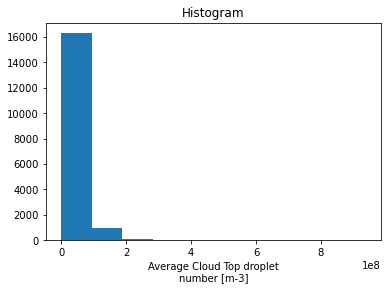

In [39]:
        ds_sel_median['ACTNL_incld'].plot()

In [40]:
        #df = ds_sel_median.to_dataframe()

In [41]:
        ls_so4 = [c for c in ds_sel_median.data_vars if 'SO4_' in c]#['SO4_NA']

In [42]:
        ls_so4

['SO4_PR', 'SO4_NA', 'SO4_A1', 'SO4_AC', 'SO4_A2']

In [43]:
        for s in ['SOA_NA','SOA_A1','OM_AC','OM_AI','OM_NI']+ls_so4:
            un = '$\micro$g/m3'
            if ds_sel_median[s].attrs['units']!=un:
                ds_sel_median[s] = ds_sel_median[s]*ds_sel_median['rho']*kg2ug
                ds_sel_median[s].attrs['units']=un
        #ds_sel_med= ds_sel_median.resample(time='D').median()

In [44]:
        df = ds_sel_median.to_dataframe()
        df = df.drop([co for co in df.columns if (('lat_' in co)|('lon_' in co))], 
                     axis=1)

        df['SOA'] = df['SOA_NA'] + df['SOA_A1']

        df['OA']  = df['SOA_NA'] + df['SOA_A1'] + df['OM_AC'] + df['OM_AI'] + df['OM_NI']
        df['POA'] = df['OM_AC']  + df['OM_AI' ] + df['OM_NI']
    
        df['SO4']=0
        for s in ls_so4:
            print(s)
            
            print(df[s].mean())
            df['SO4'] = df['SO4'] + df[s]
        
        #df['ACTNL_incld'] = df['ACTNL']/df['FCTL']
        #df['ACTREL_incld'] = df['ACTREL']/df['FCTL']
        
    
        df_daily = df#.resample('D').median()

        months = (df.index.get_level_values(0).month==7 )|(df.index.get_level_values(0).month==8  )

        df_s = df_daily[months]
        df_s.loc[:,'year'] = df_s.index.get_level_values(0).year.values

        df_s.loc[:,'T_C'] = df_s['T'].values-273.15
        #df_s.index = df_s.index.rename('date')
        df_merge = df_s#pd.merge(df_s, df_hyy_1, right_on='date', left_on='date')
        
        df_merge['year'] = df_merge.index.get_level_values(0).year

        
        dic_df[ca] = df_merge
        print(ca)
    
        months = (df.index.get_level_values(0).month==7 )|(df.index.get_level_values(0).month==8  )

        df_s = df[months]
        ds_month_mask = ds_sel.where((ds_sel['time.month']==7) | (ds_sel['time.month']==8))
        ds_sel_med_y= ds_month_mask.resample(time='Y').median()
        df_ym =ds_sel_med_y.to_dataframe()
        #df_ym = df_s.resample('Y').median()
        #df_ym.loc[:,'year'] = df_ym.index.year.values

        df_ym.loc[:,'T_C'] = df_ym['T'].values-273.15
        
        dic_df_sm[ca] = df_merge
        print(ca)

SO4_PR
0.04970574
SO4_NA
0.022963949
SO4_A1
0.14129792
SO4_AC
0.0051855976
SO4_A2
0.49827674
OsloAero_intBVOC_f19_f19_mg17_full


/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_45043/1259651114.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['year'] = df_merge.index.get_level_values(0).year


OsloAero_intBVOC_f19_f19_mg17_full


In [45]:
    return dic_df_sm, dic_df


dic_df_sm, dic_df = get_dic_df_mod(model_lev_i=-1)

SyntaxError: 'return' outside function (1131466967.py, line 1)

In [46]:
dic_df_sm[case_name].columns

Index(['GRIDAREA', 'FLNT_DRF', 'GRH2SO4', 'co2vmr', 'OD550DRY', 'DERGT05',
       'AOD_VIS', 'ACTREI', 'FSNT_DRF', 'NCONC09',
       ...
       'TOT_CLD_VISTAU_s', 'rho', 'ACTNL_incld', 'ACTREL_incld', 'SOA', 'OA',
       'POA', 'SO4', 'year', 'T_C'],
      dtype='object', length=183)

In [47]:
df_mod = dic_df_sm[case_name]

In [48]:
df_mod.index.get_level_values(1)

Float64Index([61.57894736842104, 61.57894736842104, 61.57894736842104,
              61.57894736842104,  63.4736842105263,  63.4736842105263,
               63.4736842105263,  63.4736842105263, 65.36842105263156,
              65.36842105263156,
              ...
              61.57894736842104, 61.57894736842104,  63.4736842105263,
               63.4736842105263,  63.4736842105263,  63.4736842105263,
              65.36842105263156, 65.36842105263156, 65.36842105263156,
              65.36842105263156],
             dtype='float64', name='lat', length=5208)

In [49]:
df_mod#.index.get_level_values(1)

GRIDAREA    FLNT_DRF   GRH2SO4    co2vmr  OD550DRY  \
time       lat       lon                                                        
2012-07-01 61.578947 22.5       0.0  269.064545  0.121461  0.000393  0.036554   
                     25.0       0.0  268.324158  0.135389  0.000393  0.041101   
                     27.5       0.0  269.702393  0.150608  0.000393  0.047251   
                     30.0       0.0  267.831238  0.219053  0.000393  0.048735   
           63.473684 22.5       0.0  262.371582  0.134332  0.000393  0.031766   
...                             ...         ...       ...       ...       ...   
2018-08-31 63.473684 30.0       0.0  222.266632  0.000329  0.000409  0.046934   
           65.368421 22.5       0.0  255.646454  0.023014  0.000409  0.014727   
                     25.0       0.0  246.503204  0.028408  0.000409  0.015621   
                     27.5       0.0  219.803528  0.027365  0.000409  0.021170   
                     30.0       0.0  208.872925  0.052836  0.000409  0.032729   

                            DERGT05   AOD_VIS     ACTREI    FSNT_DRF  \
time       lat       lon                                               
2012-07-01 61.578947 22.5  1.218351  0.087367   0.000000  376.850769   
                     25.0  1.214536  0.094336   0.000000  328.706421   
                     27.5  1.211253  0.099499   0.000000  312.112000   
                     30.0  1.223768  0.117504   1.000904  280.428741   
           63.473684 22.5  1.217479  0.070381   0.000000  386.307190   
...                             ...       ...        ...         ...   
2018-08-31 63.473684 30.0  1.473872  0.134922  17.214531   85.333694   
           65.368421 22.5  1.223889  0.028469   0.888342  133.145401   
                     25.0  1.205571  0.030197  23.845013  125.663849   
                     27.5  1.199093  0.057629  32.426720   90.638000   
                     30.0  1.311113  0.159478  32.140427   87.865753   

                                NCONC09  ...  TOT_CLD_VISTAU_s       rho  \
time       lat       lon                 ...                               
2012-07-01 61.578947 22.5  1.096338e+06  ...          0.000000  1.191437   
                     25.0  9.021581e+05  ...          0.000018  1.189372   
                     27.5  8.609211e+05  ...          0.009421  1.186365   
                     30.0  5.163409e+05  ...          0.229074  1.185246   
           63.473684 22.5  1.156676e+06  ...          0.000000  1.193309   
...                                 ...  ...               ...       ...   
2018-08-31 63.473684 30.0  1.826218e+05  ...          5.370134  1.209872   
           65.368421 22.5  3.078447e+05  ...          0.000000  1.226907   
                     25.0  2.902242e+05  ...          0.009866  1.223462   
                     27.5  2.294945e+05  ...          0.327122  1.221361   
                     30.0  2.810037e+05  ...          0.517163  1.218915   

                           ACTNL_incld  ACTREL_incld       SOA        OA  \
time       lat       lon                                                   
2012-07-01 61.578947 22.5   21161416.0     12.439523  0.917369  1.345906   
                     25.0   32832212.0     10.411035  0.915778  1.343573   
                     27.5   22289260.0     12.914171  0.913463  1.340176   
                     30.0   20146052.0     17.419790  0.912602  1.338912   
           63.473684 22.5   18187272.0     16.419310  0.918810  1.348020   
...                                ...           ...       ...       ...   
2018-08-31 63.473684 30.0          NaN           NaN  2.046401  2.736632   
           65.368421 22.5          NaN           NaN  2.075214  2.775164   
                     25.0          NaN           NaN  2.069387  2.767371   
                     27.5          NaN           NaN  2.065834  2.762619   
                     30.0          NaN           NaN  2.061696  2.757086   

                                POA       SO4  year       

In [50]:
mask_liq_cloudtop = df_mod['FCTL']>0.0001

In [51]:
df_mod['mask_liq_cloudtop'] = mask_liq_cloudtop

/tmp/ipykernel_45043/4230616029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['mask_liq_cloudtop'] = mask_liq_cloudtop


<AxesSubplot:xlabel='time'>

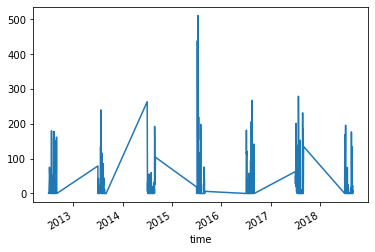

In [52]:
sel_latlon = (df_mod.index.get_level_values(2)==27.5)&(df_mod.index.get_level_values(1)==61.57894736842104)

df_mod[sel_latlon].reset_index().set_index('time')['TGCLDLWP'].plot()

<AxesSubplot:xlabel='time'>

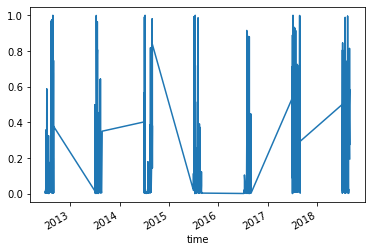

In [53]:
df_mod[mask_liq_cloudtop].reset_index().set_index('time')['FCTL'].plot()#ylim=[-.0,.01])

<AxesSubplot:xlabel='time'>

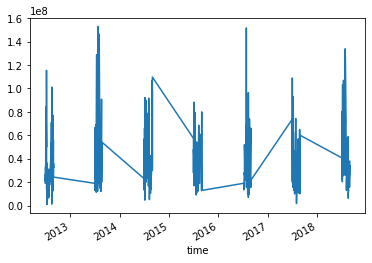

In [54]:
df_mod[mask_liq_cloudtop].reset_index().set_index('time')['ACTNL_incld'].plot()#ylim=[-.0,.01])

#### Mask values that don't have cloud top liquid

In [55]:
df_mod = df_mod[df_mod['mask_liq_cloudtop']]

In [56]:
df_mod['CWP_qcut']=pd.qcut(df_mod['TGCLDLWP'],6)# bins=bins, labels=labels)§

df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)



/tmp/ipykernel_45043/3249190625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_qcut']=pd.qcut(df_mod['TGCLDLWP'],6)# bins=bins, labels=labels)§
/tmp/ipykernel_45043/3249190625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)


In [57]:
bins = pd.IntervalIndex.from_breaks([ 10,  30,  50,  70, 90, 110, 130,500])


df_mod['CWP_cut']=pd.cut(df_mod['TGCLDLWP'], bins=bins)#, labels=labels)

df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)

/tmp/ipykernel_45043/826289808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_cut']=pd.cut(df_mod['TGCLDLWP'], bins=bins)#, labels=labels)
/tmp/ipykernel_45043/826289808.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)


## Category of OA concentration

In [58]:
df_mod['OA_low'] = df_mod['OA']<df_mod['OA'].quantile(.34)
df_mod['OA_high']= df_mod['OA']>df_mod['OA'].quantile(.66)

/tmp/ipykernel_45043/1026901322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['OA_low'] = df_mod['OA']<df_mod['OA'].quantile(.34)
/tmp/ipykernel_45043/1026901322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['OA_high']= df_mod['OA']>df_mod['OA'].quantile(.66)


In [59]:
#df_mod['OA_low'].loc[:,:] = df_mod['OA']<df_mod['OA'].quantile(.34)
mid_range = ( df_mod['OA'].quantile(.34)<df_mod['OA']) & (df_mod['OA']<df_mod['OA'].quantile(.66))
df_mod['OA_mid_range'] = mid_range

/tmp/ipykernel_45043/1710207095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['OA_mid_range'] = mid_range


In [60]:

df_mod=df_mod.assign(OA_category= pd.NA)
df_mod.loc[df_mod['OA_high'], 'OA_category'] = 'OA high'
df_mod.loc[df_mod['OA_low'], 'OA_category'] = 'OA low'



In [61]:
df_mod[(df_mod.index.get_level_values('lat') >65)& (df_mod.index.get_level_values('lon') == 25.0)]

,,,GRIDAREA,FLNT_DRF,GRH2SO4,co2vmr,OD550DRY,DERGT05,AOD_VIS,ACTREI,FSNT_DRF,NCONC09,...,T_C,mask_liq_cloudtop,CWP_qcut,CWP_qcutl,CWP_cut,CWP_cutl,OA_low,OA_high,OA_mid_range,OA_category
time,lat,lon,,,,,,,,,,,,,,,,,,,,,
2012-07-14,65.368421,25.0,0.0,262.553711,0.043997,0.000393,0.016567,1.211786,0.044269,0.37745,364.758911,249316.984375,...,16.994293,True,"(-0.001, 2.416]",1.2075,NaN,NaN,True,False,False,OA low
2012-07-21,65.368421,25.0,0.0,246.818878,0.033298,0.000393,0.011689,1.151429,0.031514,0.00000,289.070953,84239.500000,...,12.400909,True,"(15.218, 39.671]",27.4445,"(10.0, 30.0]",20.0,True,False,False,OA low
2012-07-24,65.368421,25.0,0.0,257.248657,0.025964,0.000393,0.031032,1.229139,0.070954,0.00000,274.182373,712278.562500,...,18.363037,True,"(2.416, 15.218]",8.8170,NaN,NaN,False,True,False,OA high
2012-07-26,65.368421,25.0,0.0,259.420776,0.039218,0.000393,0.014321,1.192416,0.031435,0.00000,323.889435,157467.968750,...,16.669769,True,"(-0.001, 2.416]",1.2075,NaN,NaN,False,True,False,OA high
2012-08-10,65.368421,25.0,0.0,241.846649,0.080115,0.000393,0.024641,1.159778,0.048669,0.00000,210.805420,123812.687500,...,13.414276,True,"(15.218, 39.671]",27.4445,"(10.0, 30.0]",20.0,True,False,False,OA low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-11,65.368421,25.0,0.0,263.441833,0.023104,0.000409,0.023362,1.167025,0.047836,0.00000,192.998566,545782.312500,...,16.812103,True,"(-0.001, 2.416]",1.2075,NaN,NaN,False,False,True,<NA>
2018-08-14,65.368421,25.0,0.0,223.953217,0.030982,0.000409,0.013140,1.030322,0.037923,0.00000,134.857483,32750.681641,...,9.730255,True,"(39.671, 81.058]",60.3645,"(70.0, 90.0]",80.0,True,False,False,OA low
2018-08-19,65.368421,25.0,0.0,256.437805,0.018825,0.000409,0.014215,1.222689,0.039828,0.00000,186.966507,531282.750000,...,14.308990,True,"(-0.001, 2.416]",1.2075,NaN,NaN,False,False,True,<NA>


In [62]:
import seaborn as sns

<AxesSubplot:ylabel='Frequency'>

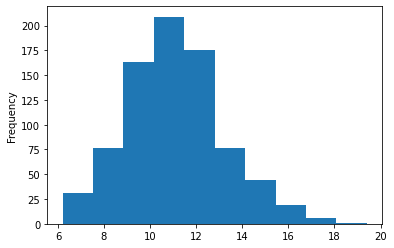

In [91]:
df_mod['ACTREL_incld'].plot.hist()

In [107]:
df_mod = df_mod[((df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>2))& (df_mod['ACTREL_incld']>2)]

378


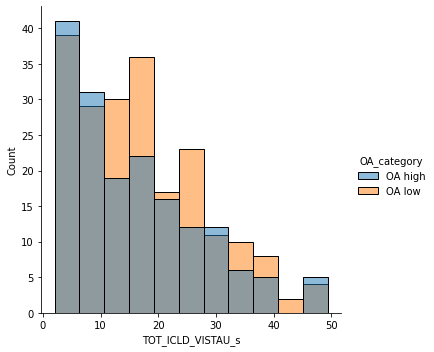

In [108]:
_df = (df_mod[((df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>2))& (df_mod['ACTREL_incld']>2)])
_df = _df[_df['TOT_ICLD_VISTAU_s']<50]
sns.displot(#x='TGCLDLWP', 
            x='TOT_ICLD_VISTAU_s',
            data=_df,
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(_df['OA_category']))

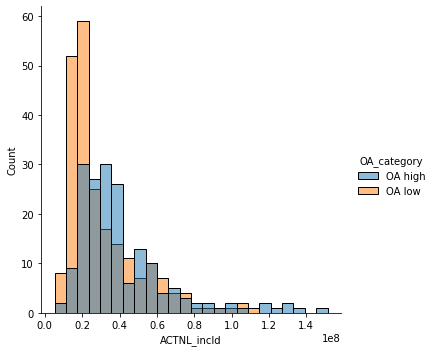

In [109]:
sns.displot(#x='TGCLDLWP', 
            x='ACTNL_incld',
            data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            hue='OA_category',
           #kind='swarm'
           )
#plt.ylim([0,250])

In [110]:
import seaborn as sns

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


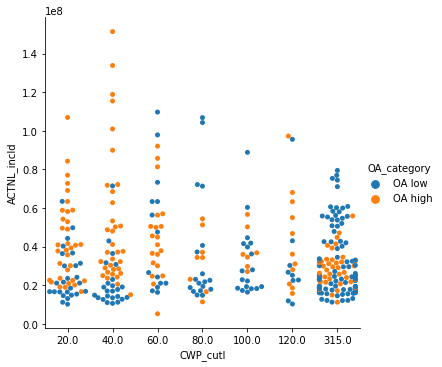

In [111]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            #data=df_mod.reset_index(),
            #data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='swarm'
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


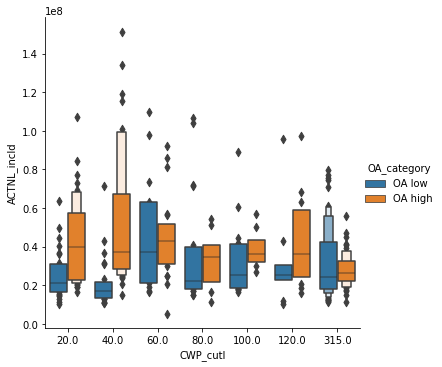

In [113]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            #data=df_mod.reset_index(),
            #data=df_mod[~df_mod['OA_mid_range']].reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='boxen'
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


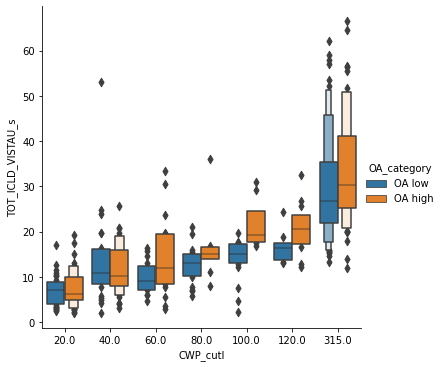

In [114]:
sns.catplot(x='CWP_cutl', 
            y='TOT_ICLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg,

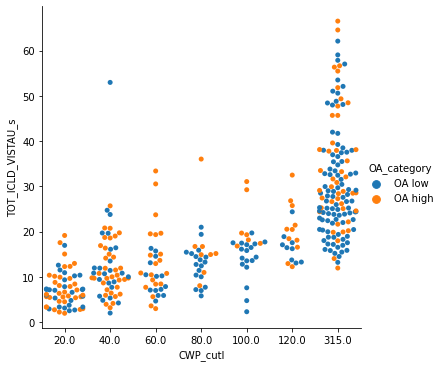

In [115]:
sns.catplot(x='CWP_cutl', 
            y='TOT_ICLD_VISTAU_s',
            #data=df_mod.reset_index(),
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
           kind='swarm'
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


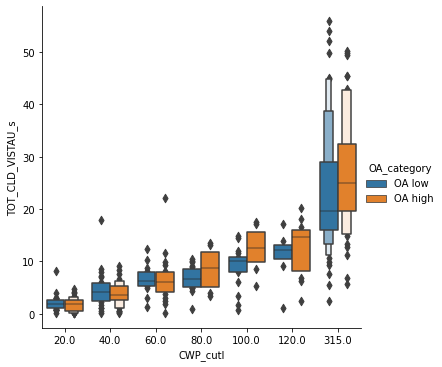

In [116]:
sns.catplot(x='CWP_cutl', 
            y='TOT_CLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue ='OA_category',
            kind='boxen',
            hue_order=['OA low','OA high'],
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

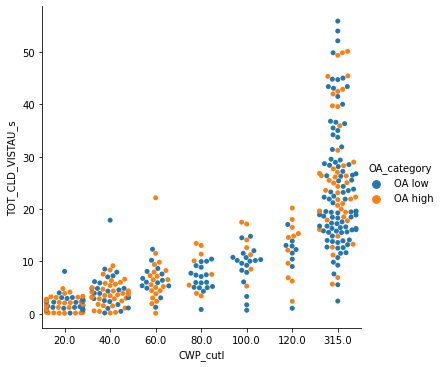

In [117]:
sns.catplot(x='CWP_cutl', 
            y='TOT_CLD_VISTAU_s',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue ='OA_category',
            kind='swarm',
            hue_order=['OA low','OA high'],
           )
#plt.ylim([0,250])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


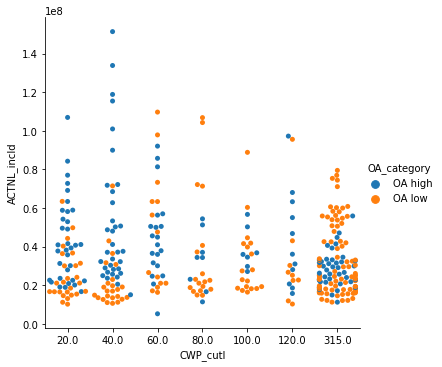

In [118]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),

            hue='OA_category',
           kind='swarm'
           )

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


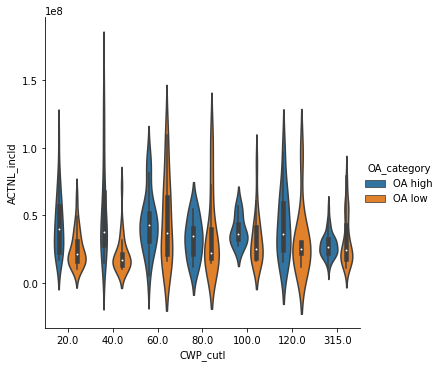

In [119]:
sns.catplot(x='CWP_cutl', 
            y='ACTNL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),

            hue='OA_category',
            kind='violin'
           )

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


(0.0, 25.0)

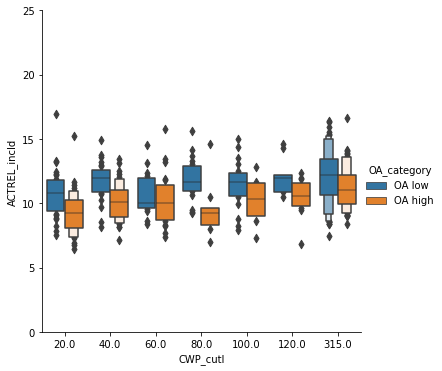

In [120]:
sns.catplot(x='CWP_cutl', 
            y='ACTREL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='boxen',
           )
plt.ylim([0,25])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


(0.0, 25.0)

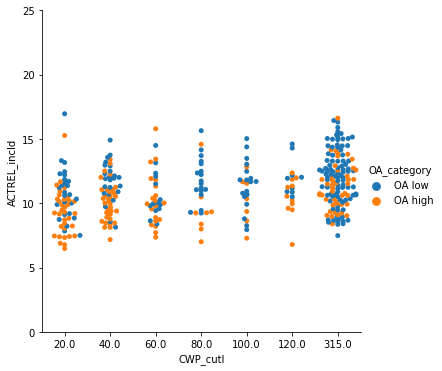

In [121]:
sns.catplot(x='CWP_cutl', 
            y='ACTREL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue_order=['OA low','OA high'],

            hue='OA_category',
            kind='swarm',
           )
plt.ylim([0,25])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


(0.0, 25.0)

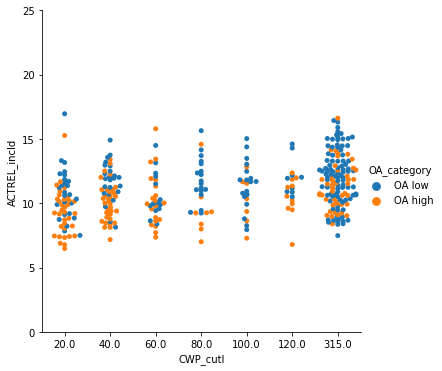

In [122]:
sns.catplot(x='CWP_cutl', 
            y='ACTREL_incld',
            data=df_mod[df_mod['OA_category'].notna()].reset_index(),
            hue ='OA_category',
            kind='swarm',
            hue_order=['OA low','OA high'],
           )
#plt.ylim([0,250])
plt.ylim([0,25])